In [ ]:
#DEEEP LEARNING METHOD FOR SENTIMENT ANALYSIS

In [ ]:
!pip install nltk
!pip install contractions
!pip install tensorflow
#!pip install tensorflow-gpu

In [ ]:
pip install pandas 

In [ ]:
!pip install vaderSentiment
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import tensorflow as tf
print(tf.__version__)
print("Our tensorflow version = 2.2.0-rc3")
import csv
import numpy as np
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
import contractions as cont_lib

import matplotlib.pyplot as plt

# Checking for GPU 
import timeit
from collections import Counter  # to counts the distribution of classes in the dataset

tf.test.is_gpu_available #show if tensorflow has accuss to cuda gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.5.0
Our tensorflow version = 2.2.0-rc3
Found GPU at: /device:GPU:0


In [ ]:
# use glove 100 file
embedding_dim = 64 # This gives the size of the feature vector
max_length = 30 # max word length of sentences held in sequences
# max_length = df['text_after_preprocess'].apply(lambda x : len(x.split(' '))).quantile(0.99)
trunc_type = 'post' # we truncate at the end
padding_type = 'post' #we padd at the end
oov_tok = '<OOV>'
training_portion = .8 # proportion of training data that is split

# CNN parameters # verified in another notebook
maxLength = 40 # max word length of sentences held in sequences.  Cutting it in half drops accuracy and worsens loss by about 1%. 
eDepth = 200 #depth of the embedding layer.   
bSize = 128 #batch size for conv layer 
fSize = 5 #feature size for conv layer
cEpochs = 10 #epoch number for conv layer 
dOut = 0.3 #dropout rate for drop layer
cActivation = 'relu' #activation type for conv layer. Default was 'relu'

In [ ]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = 'ISO-8859–1',  names=["target", "ids", "date", "flag", "user", "text"])

In [ ]:
df.head(7)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug


In [ ]:
def contractions(text):
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'a", " have", text)
    return text

def preprocess(text):
    # Remove link,user and special characters
    text = re.sub('@[^ ]+ ', '', text) #remove user @ tags
    text = re.sub('http[^ ]+ ', '', text) #remove hyperlinks 
    text = re.sub('[^a-zA-Z1-9]', ' ', text) #remove special characters left over 
    text = re.sub(r'\s+', ' ', text) #remove multiple spaces
    text = text.lstrip() #remove trailing spaces
    text = text.rstrip()    
    text = contractions(text)
    tokens = []
    for token in text.split():
        tokens.append(cont_lib.fix(token))
    return " ".join(tokens)

In [ ]:

sent = "you've three, so can't dont"
print(contractions(sent))
print(cont_lib.fix(contractions(sent)))

you have three, so can not dont
you have three, so can not do not


In [ ]:
df.text= df.text.apply(lambda x: preprocess(x))

In [ ]:
df['target'].value_counts()

4    800000
0    800000
Name: target, dtype: int64

In [ ]:
label_encoding = {0: "negative", 2: "neutral", 4: "positive"}
df.target = df.target.apply(lambda x: label_encoding[int(x)])

In [ ]:
df.head(1)

,target,ids,date,flag,user,text
0,negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,Awww that s a bummer You shoulda got David Carr of Third Day to do it D


In [ ]:
# check is there are any null values. If yes, then drop those
df = df[df['text'].notnull()]
df = df[df['text']!= '']
df = df.reset_index(drop=True)
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [ ]:
df['text'].apply(lambda x : len(x.split(' '))).quantile(0.99)

30.0

In [ ]:
df.to_csv("prepro_final_train.csv", sep=";", index = False)

In [ ]:
df = pd.read_csv("prepro_final_train.csv", sep=";")
df.head(1)

,target,ids,date,flag,user,text
0,negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,Awww that s a bummer You shoulda got David Carr of Third Day to do it D


In [ ]:
data = df[['target','text']].copy()
data['text'] = data['text'].astype(str)
display(data.head(1))
data.shape

,target,text
0,negative,Awww that s a bummer You shoulda got David Carr of Third Day to do it D


(1596482, 2)

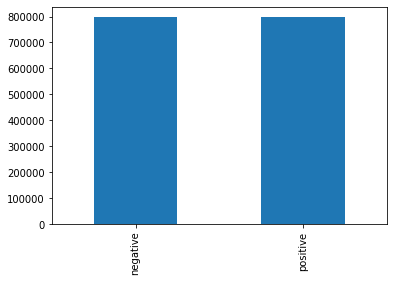

In [ ]:
class_dist = data.target.value_counts()
class_dist.plot(kind='bar')
plt.show()

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data['text'].tolist(), data['target'].tolist(), test_size=0.20, random_state=17)
print(X_train[1])
print(Y_train[1])

I am about to go watch Americas Most Wanted
positive


In [ ]:

# get an idea of the distribution in train dataset 
count = Counter(Y_train)
print('Distribution of the classes in Train dataset:', count)

Distribution of the classes in Train dataset: Counter({'negative': 638603, 'positive': 638582})


In [ ]:
# tokenize the sentences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# We note the vocab_size :  total number of words in text +1 since 0 is used for padding
vocab_size = len(tokenizer.word_index)+1 

# create sequences 
X_train = tokenizer.texts_to_sequences(X_train) 
X_test = tokenizer.texts_to_sequences(X_test)

#pad sequences that are less than the max so that all sequences are the same length 
X_train_final = pad_sequences(X_train, padding=padding_type, maxlen=max_length, truncating=trunc_type) 
X_test_final = pad_sequences(X_test, padding=padding_type, maxlen=max_length, truncating=trunc_type)

# do the same for label 
label_tokenizer = Tokenizer()

label_tokenizer.fit_on_texts(Y_train)
Y_train_final = np.array(label_tokenizer.texts_to_sequences(Y_train))

label_tokenizer.fit_on_texts(Y_test)
Y_test_final = np.array(label_tokenizer.texts_to_sequences(Y_test))

In [ ]:
print('Total no. of Tokens:', vocab_size,'\n')
print('tweet : ', X_train[2])
print('tweet : ', Y_train[2],'\n')
print('model interpretation of the tweet : ', X_train_final[2] , '\n')
print('model interpretation of the tweet : ', Y_train_final[2] , '\n')

print(X_train_final.shape)
print(Y_train_final.shape)

print(X_test_final.shape)
print(Y_test_final.shape)

Total no. of Tokens: 272582 

tweet :  [97900, 1, 54, 2, 38, 4, 4315, 41, 989, 1646, 989, 20, 3, 4529, 1877]
tweet :  positive 

model interpretation of the tweet :  [97900     1    54     2    38     4  4315    41   989  1646   989    20
     3  4529  1877     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0] 

model interpretation of the tweet :  [2] 

(1277185, 30)
(1277185, 1)
(319297, 30)
(319297, 1)


In [ ]:
def plot_graphs(history, string_needed):
  plt.plot(history.history[string_needed])
  plt.plot(history.history['val_'+string_needed])
  plt.xlabel("Epoch values")
  plt.ylabel(string_needed)
  plt.legend(['train', 'test'], loc = 'upper left')
  plt.show()

In [ ]:
lstm_1 = tf.keras.Sequential()
lstm_1.add(tf.keras.layers.Embedding(input_dim = vocab_size+1,input_length=30, output_dim=64))
lstm_1.add(tf.keras.layers.LSTM(128))
lstm_1.add(tf.keras.layers.Dense(64, activation='relu'))
lstm_1.add(tf.keras.layers.Dense(3, activation='softmax'))
lstm_1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 64)            17445312  
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 195       
Total params: 17,552,579
Trainable params: 17,552,579
Non-trainable params: 0
_________________________________________________________________


In [ ]:

#train model 
lstm_arch_1 = lstm_1.fit(X_train_final, Y_train_final,batch_size=1024, epochs=10, verbose=1, validation_split=0.2) 


Epoch 1/10
998/998 [==============================] - 163s 162ms/step - loss: 0.4928 - accuracy: 0.7398 - val_loss: 0.4196 - val_accuracy: 0.8064
Epoch 2/10
998/998 [==============================] - 162s 162ms/step - loss: 0.3777 - accuracy: 0.8304 - val_loss: 0.4017 - val_accuracy: 0.8203
Epoch 3/10
998/998 [==============================] - 161s 161ms/step - loss: 0.3334 - accuracy: 0.8536 - val_loss: 0.4106 - val_accuracy: 0.8195
Epoch 4/10
998/998 [==============================] - 160s 160ms/step - loss: 0.2988 - accuracy: 0.8708 - val_loss: 0.4440 - val_accuracy: 0.8142
Epoch 5/10
998/998 [==============================] - 161s 161ms/step - loss: 0.2689 - accuracy: 0.8846 - val_loss: 0.4609 - val_accuracy: 0.8120
Epoch 6/10
998/998 [==============================] - 161s 161ms/step - loss: 0.2437 - accuracy: 0.8955 - val_loss: 0.5046 - val_accuracy: 0.8090
Epoch 7/10
998/998 [==============================] - 160s 160ms/step - loss: 0.2233 - accuracy: 0.9040 - val_loss: 0.5765 -

In [ ]:
lstm_score_1 = lstm_1.evaluate(X_test_final, Y_test_final, verbose=1)

9979/9979 [==============================] - 31s 3ms/step - loss: 0.7128 - accuracy: 0.7974


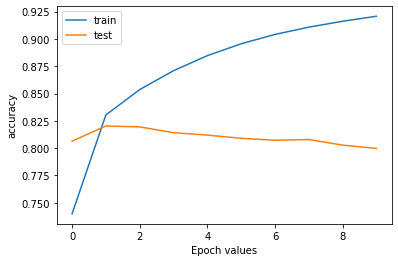

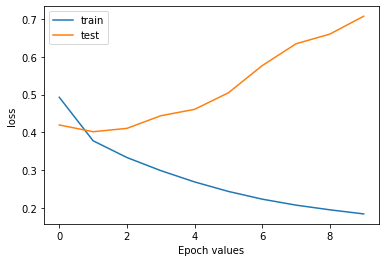

In [ ]:
plot_graphs(lstm_arch_1, "accuracy")
plot_graphs(lstm_arch_1, "loss");

In [ ]:
#file used for glove embeddings 
#embeddingsFile = '/content/drive/My Drive/glove.twitter.27B.100d.txt' 
embeddingsFile = "glove.twitter.27B.100d.txt"
embedding_dim=100
embeddings_index = {};
with open(embeddingsFile) as file:
    for line in file:
        values = line.split();
        phrase = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embeddings_index[phrase] = coefficients;
        
#the input matrix for the embedding_layer.  must be size (batch, input_length) 
#each column wil contain the GloVe word embeddings for the words from each row

embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

In [ ]:
lstm_3_relu = tf.keras.Sequential()
lstm_3_relu.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim=100, input_length=max_length, weights=[embeddings_matrix], trainable=False))
lstm_3_relu.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25)))
lstm_3_relu.add(tf.keras.layers.Dense(64, activation='relu'))
lstm_3_relu.add(tf.keras.layers.Dense(3, activation='softmax'))
lstm_3_relu.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_3_relu.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           27258200  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 27,351,131
Trainable params: 92,931
Non-trainable params: 27,258,200
_________________________________________________________________


In [ ]:
#train model 
lstm_arch_3_relu = lstm_3_relu.fit(X_train_final, Y_train_final,batch_size=256, epochs=10, verbose=1, validation_split=0.2) 


Epoch 1/10
3992/3992 [==============================] - 37s 9ms/step - loss: 0.4620 - accuracy: 0.7795 - val_loss: 0.4177 - val_accuracy: 0.8082
Epoch 2/10
3992/3992 [==============================] - 34s 9ms/step - loss: 0.4204 - accuracy: 0.8049 - val_loss: 0.3989 - val_accuracy: 0.8185
Epoch 3/10
3992/3992 [==============================] - 34s 9ms/step - loss: 0.4075 - accuracy: 0.8128 - val_loss: 0.3936 - val_accuracy: 0.8220
Epoch 4/10
3992/3992 [==============================] - 35s 9ms/step - loss: 0.3991 - accuracy: 0.8175 - val_loss: 0.3928 - val_accuracy: 0.8245
Epoch 5/10
3992/3992 [==============================] - 34s 9ms/step - loss: 0.3934 - accuracy: 0.8208 - val_loss: 0.3847 - val_accuracy: 0.8278
Epoch 6/10
3992/3992 [==============================] - 35s 9ms/step - loss: 0.3893 - accuracy: 0.8226 - val_loss: 0.3921 - val_accuracy: 0.8252
Epoch 7/10
3992/3992 [==============================] - 36s 9ms/step - loss: 0.3859 - accuracy: 0.8252 - val_loss: 0.3826 - val_ac

In [ ]:
lstm_score_3_relu = lstm_3_relu.evaluate(X_test_final, Y_test_final, verbose=1)

9979/9979 [==============================] - 37s 4ms/step - loss: 0.3913 - accuracy: 0.8273


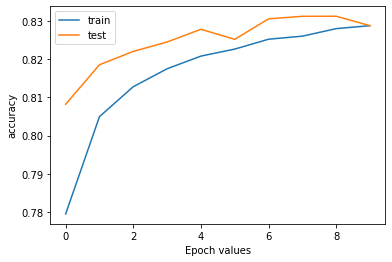

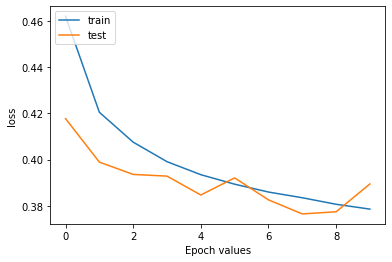

In [ ]:
plot_graphs(lstm_arch_3_relu, "accuracy")
plot_graphs(lstm_arch_3_relu, "loss")

In [ ]:
lstm_4_dropout = tf.keras.Sequential()
lstm_4_dropout.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim=100, input_length=max_length, weights=[embeddings_matrix], trainable=False))
lstm_4_dropout.add(tf.keras.layers.SpatialDropout1D(0.25))
lstm_4_dropout.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25)))
lstm_4_dropout.add(tf.keras.layers.Dense(64, activation='relu'))
lstm_4_dropout.add(tf.keras.layers.Dense(3, activation='softmax'))
lstm_4_dropout.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
lstm_4_dropout.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           27258200  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 27,351,131
Trainable params: 92,931
Non-trainable params: 27,258,200
_________________________________________________________________


In [ ]:
#train model 
lstm_arch_4_dropout = lstm_4_dropout.fit(X_train_final, Y_train_final,batch_size=256, epochs=10, verbose=1, validation_split=0.2) 


Epoch 1/10
3992/3992 [==============================] - 39s 9ms/step - loss: 0.4921 - accuracy: 0.7590 - val_loss: 0.4282 - val_accuracy: 0.8024
Epoch 2/10
3992/3992 [==============================] - 36s 9ms/step - loss: 0.4496 - accuracy: 0.7874 - val_loss: 0.4131 - val_accuracy: 0.8100
Epoch 3/10
3992/3992 [==============================] - 36s 9ms/step - loss: 0.4362 - accuracy: 0.7953 - val_loss: 0.4042 - val_accuracy: 0.8161
Epoch 4/10
3992/3992 [==============================] - 36s 9ms/step - loss: 0.4278 - accuracy: 0.8007 - val_loss: 0.3988 - val_accuracy: 0.8190
Epoch 5/10
3992/3992 [==============================] - 36s 9ms/step - loss: 0.4225 - accuracy: 0.8039 - val_loss: 0.3943 - val_accuracy: 0.8212
Epoch 6/10
3992/3992 [==============================] - 36s 9ms/step - loss: 0.4184 - accuracy: 0.8061 - val_loss: 0.3942 - val_accuracy: 0.8220
Epoch 7/10
3992/3992 [==============================] - 35s 9ms/step - loss: 0.4152 - accuracy: 0.8079 - val_loss: 0.3926 - val_ac

In [ ]:
lstm_score_4_dropout = lstm_4_dropout.evaluate(X_test_final, Y_test_final, verbose=1)

9979/9979 [==============================] - 37s 4ms/step - loss: 0.3937 - accuracy: 0.8228


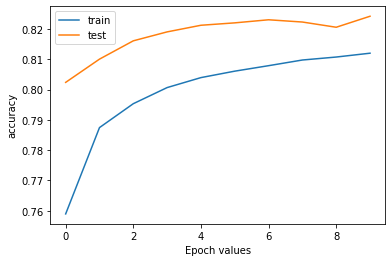

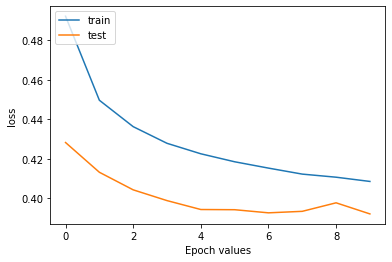

In [ ]:
plot_graphs(lstm_arch_4_dropout, "accuracy")
plot_graphs(lstm_arch_4_dropout, "loss")

In [ ]:
hybrid_1 = tf.keras.Sequential()
hybrid_1.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim=100, input_length=max_length, weights=[embeddings_matrix], trainable=False))
hybrid_1.add(tf.keras.layers.Conv1D(bSize, 5, activation='relu'))
hybrid_1.add(tf.keras.layers.Dropout(dOut))
hybrid_1.add(tf.keras.layers.MaxPooling1D())
hybrid_1.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25)))
hybrid_1.add(tf.keras.layers.Dense(64, activation='relu'))
hybrid_1.add(tf.keras.layers.Dense(3, activation='softmax'))
hybrid_1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
hybrid_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 100)           27258200  
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 128)           64128     
_________________________________________________________________
dropout (Dropout)            (None, 26, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 13, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                

In [ ]:
#train model 
hybrid_arch_1 = hybrid_1.fit(X_train_final, Y_train_final,batch_size=256, epochs=10, verbose=1, validation_split=0.2) 


Epoch 1/10
3992/3992 [==============================] - 63s 9ms/step - loss: 0.4537 - accuracy: 0.7847 - val_loss: 0.4154 - val_accuracy: 0.8090
Epoch 2/10
3992/3992 [==============================] - 34s 9ms/step - loss: 0.4185 - accuracy: 0.8061 - val_loss: 0.4076 - val_accuracy: 0.8135
Epoch 3/10
3992/3992 [==============================] - 35s 9ms/step - loss: 0.4081 - accuracy: 0.8124 - val_loss: 0.3992 - val_accuracy: 0.8174
Epoch 4/10
3992/3992 [==============================] - 35s 9ms/step - loss: 0.4017 - accuracy: 0.8157 - val_loss: 0.3956 - val_accuracy: 0.8207
Epoch 5/10
3992/3992 [==============================] - 35s 9ms/step - loss: 0.3971 - accuracy: 0.8187 - val_loss: 0.3925 - val_accuracy: 0.8221
Epoch 6/10
3992/3992 [==============================] - 34s 9ms/step - loss: 0.3937 - accuracy: 0.8205 - val_loss: 0.3904 - val_accuracy: 0.8227
Epoch 7/10
3992/3992 [==============================] - 35s 9ms/step - loss: 0.3908 - accuracy: 0.8221 - val_loss: 0.3888 - val_ac

In [ ]:
hybrid_score_1 = hybrid_1.evaluate(X_test_final, Y_test_final, verbose=1)

9979/9979 [==============================] - 35s 3ms/step - loss: 0.3871 - accuracy: 0.8243


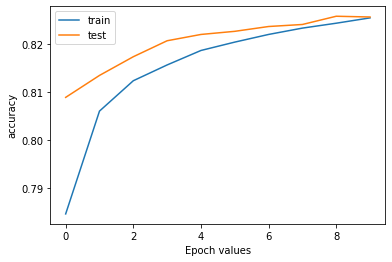

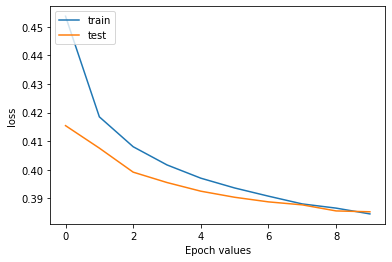

In [ ]:
plot_graphs(hybrid_arch_1, "accuracy")
plot_graphs(hybrid_arch_1, "loss");

In [ ]:
hybrid_2 = tf.keras.Sequential()
hybrid_2.add(tf.keras.layers.Embedding(input_dim = vocab_size, output_dim=100, input_length=max_length, weights=[embeddings_matrix], trainable=False))
hybrid_2.add(tf.keras.layers.SpatialDropout1D(0.25))
hybrid_2.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.25,return_sequences=True)))
hybrid_2.add(tf.keras.layers.Conv1D(64,4,activation=cActivation ))
hybrid_2.add(tf.keras.layers.GlobalMaxPool1D())
hybrid_2.add(tf.keras.layers.Dense(64, activation='relu'))
hybrid_2.add(tf.keras.layers.Dense(3, activation='softmax'))

hybrid_2.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
hybrid_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 100)           27258200  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 30, 100)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 30, 128)           84480     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 27, 64)            32832     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

In [ ]:
#train model 
hybrid_arch_2 = hybrid_2.fit(X_train_final, Y_train_final,batch_size=256, epochs=10, verbose=1, validation_split=0.2) 


Epoch 1/10
3992/3992 [==============================] - 43s 10ms/step - loss: 0.4751 - accuracy: 0.7703 - val_loss: 0.4166 - val_accuracy: 0.8095
Epoch 2/10
3992/3992 [==============================] - 40s 10ms/step - loss: 0.4321 - accuracy: 0.7986 - val_loss: 0.3987 - val_accuracy: 0.8181
Epoch 3/10
3992/3992 [==============================] - 40s 10ms/step - loss: 0.4199 - accuracy: 0.8055 - val_loss: 0.3988 - val_accuracy: 0.8191
Epoch 4/10
3992/3992 [==============================] - 40s 10ms/step - loss: 0.4121 - accuracy: 0.8101 - val_loss: 0.3910 - val_accuracy: 0.8236
Epoch 5/10
3992/3992 [==============================] - 40s 10ms/step - loss: 0.4072 - accuracy: 0.8127 - val_loss: 0.3885 - val_accuracy: 0.8263
Epoch 6/10
3992/3992 [==============================] - 40s 10ms/step - loss: 0.4033 - accuracy: 0.8152 - val_loss: 0.3865 - val_accuracy: 0.8259
Epoch 7/10
3992/3992 [==============================] - 39s 10ms/step - loss: 0.4008 - accuracy: 0.8163 - val_loss: 0.3833 -

In [ ]:
hybrid_score_2 = hybrid_2.evaluate(X_test_final, Y_test_final, verbose=1)

9979/9979 [==============================] - 41s 4ms/step - loss: 0.3835 - accuracy: 0.8274


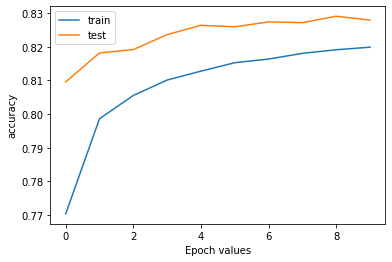

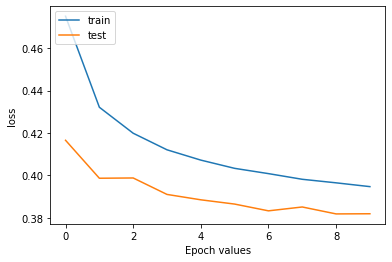

In [ ]:
plot_graphs(hybrid_arch_2, "accuracy")
plot_graphs(hybrid_arch_2, "loss");

In [ ]:
#MACHINE LEARNING CODE SAI

In [ ]:
import pandas as pd
#pandas
import numpy as np
#numpy
import matplotlib.pyplot as plt
#matplotlib
import seaborn as sns
#seaborn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
#sklearn
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
#from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
#keras
import tensorflow as tf
#tensorflow
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
#nltk
import os
import nltk # For NLP
import re # For Regex 
import string # For punctuation
#other useful stuff
from wordcloud import WordCloud, STOPWORDS
#wordclouds and cloud stopwords
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'latin', header=None)

In [ ]:
data.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [ ]:
data = data.rename(columns={0: 'target', 1: 'ids', 2: 'date', 3: 'flag', 4: 'user', 5: 'text'})

In [ ]:
data.head(10)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [ ]:
missing_data = data.isna().sum().sort_values(ascending=False)
percentage_missing = round((data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)*100,2)
missing_info = pd.concat([missing_data,percentage_missing],keys=['Missing values','Percentage'],axis=1)
missing_info.style.background_gradient()

,Missing values,Percentage
text,0,0.000000
user,0,0.000000
flag,0,0.000000
date,0,0.000000
ids,0,0.000000
target,0,0.000000


In [ ]:
pd.set_option('display.max_colwidth', -1)
data[data['target']==0]['text'].head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
1    is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!    
2    @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds                          
3    my whole body feels itchy and like its on fire                                                                     
4    @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there.     
Name: text, dtype: object

In [ ]:
data[data['target']==4]['text'].head

<bound method NDFrame.head of 800000     I LOVE @Health4UandPets u guys r the best!!                                                                                              
800001     im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!                                                                 
800002     @DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. 
800003     Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup                                 
800004     @LovesBrooklyn2 he has that effect on everyone                                                                                           
                                ...                                                                                                                 
1599995    Just woke up. Having no school is the best feeling ever          

In [ ]:
data[data['target']==2]['text'].head

<bound method NDFrame.head of Series([], Name: text, dtype: object)>

In [ ]:
data['target'] = data['target'].replace([0, 4],['negative','positive'])

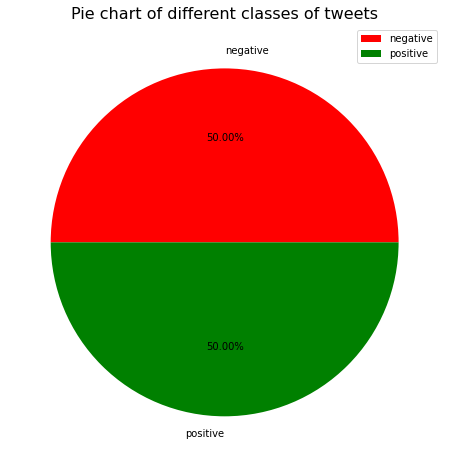

In [ ]:
fig = plt.figure(figsize=(8,8))
targets = data.groupby('target').size()
targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['red','green'])
plt.title("Pie chart of different classes of tweets",fontsize=16)
plt.ylabel("")
plt.legend()
plt.show()

In [ ]:
data['target'].value_counts()

positive    800000
negative    800000
Name: target, dtype: int64

In [ ]:
data['length'] = data.text.str.split().apply(len)

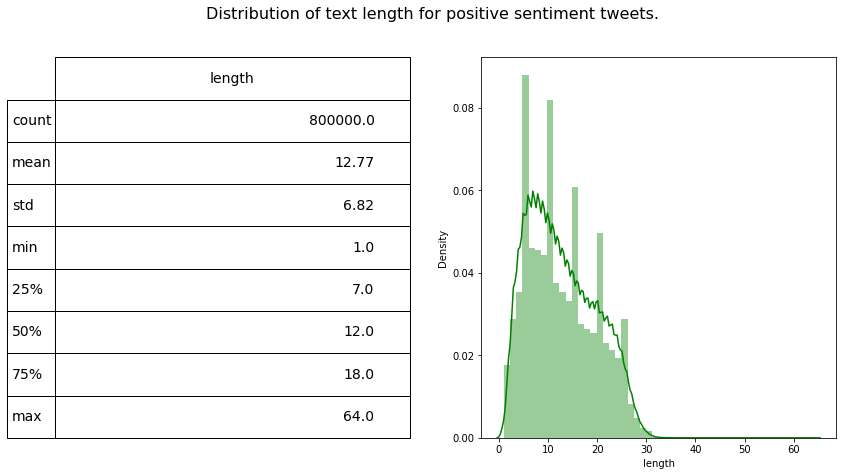

In [ ]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='positive']['length'], ax=ax1,color='green')
describe = data.length[data.target=='positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

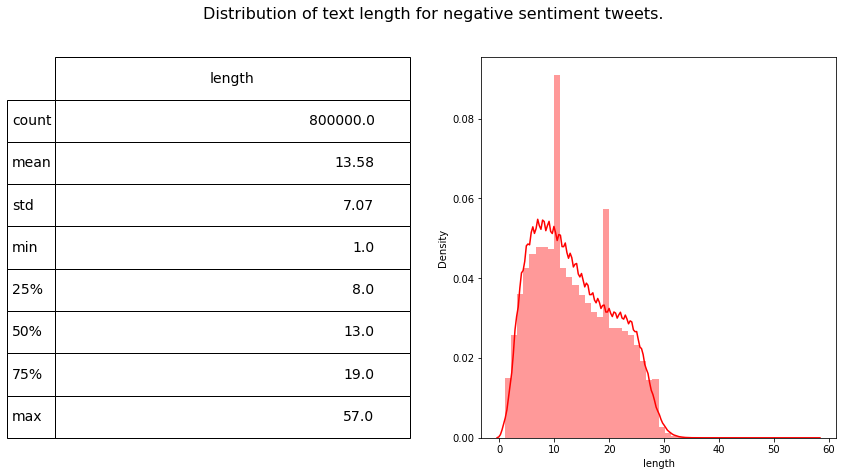

In [ ]:
fig = plt.figure(figsize=(14,7))

ax1 = fig.add_subplot(122)
sns.distplot(data[data['target']=='negative']['length'], ax=ax1,color='red')
describe = data.length[data.target=='negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for negative sentiment tweets.', fontsize=16)

plt.show()

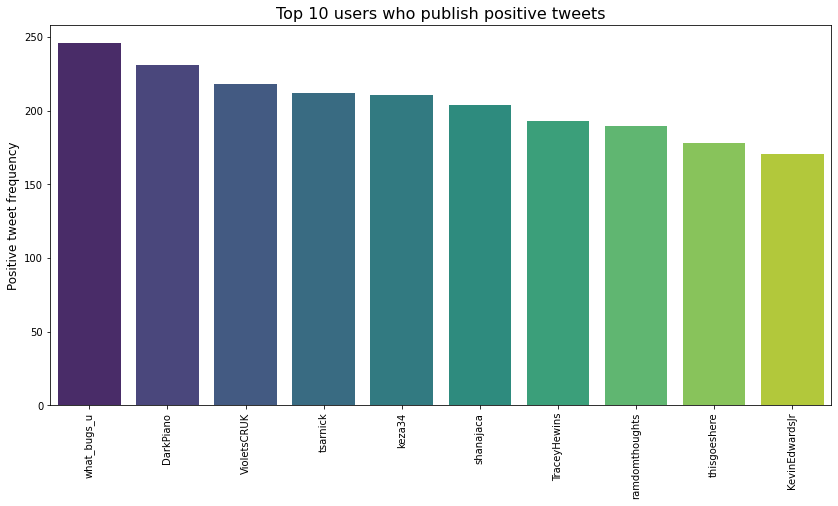

In [ ]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='positive']['user'].value_counts()[:10].index, \
                           y=data[data['target']=='positive']['user'].value_counts()[:10],palette='viridis')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Positive tweet frequency',fontsize=12)
plt.title('Top 10 users who publish positive tweets',fontsize=16)
plt.show()

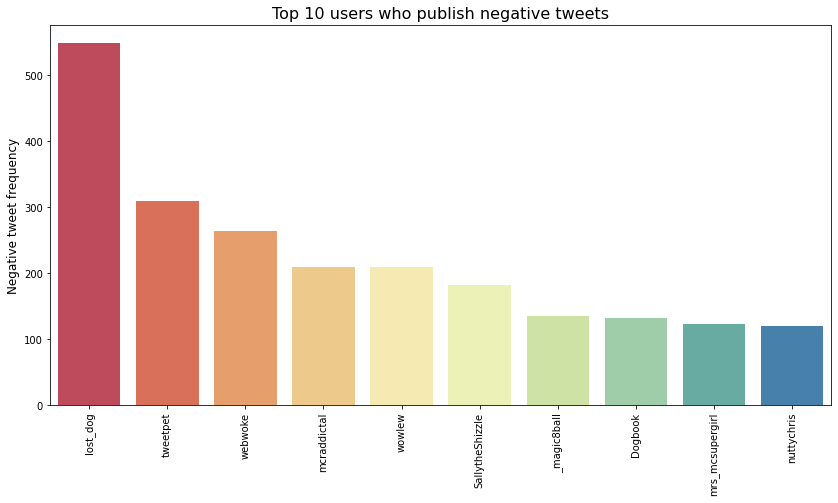

In [ ]:
plt.figure(figsize=(14,7))
common_keyword=sns.barplot(x=data[data['target']=='negative']['user'].value_counts()[:10].index, \
                           y=data[data['target']=='negative']['user'].value_counts()[:10],palette='Spectral')
common_keyword.set_xticklabels(common_keyword.get_xticklabels(),rotation=90)
common_keyword.set_ylabel('Negative tweet frequency',fontsize=12)
plt.title('Top 10 users who publish negative tweets',fontsize=16)
plt.show()

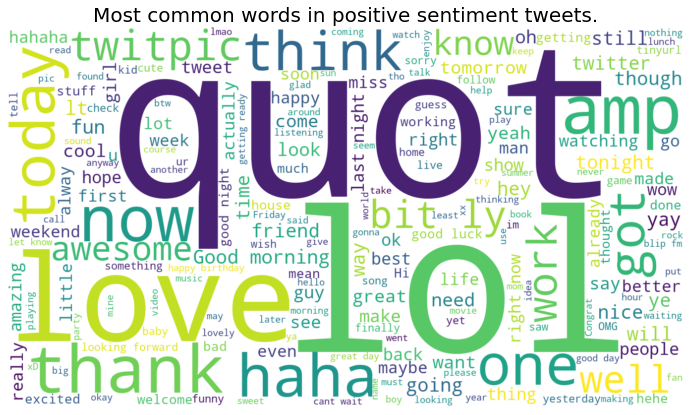

In [ ]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='positive'].text))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in positive sentiment tweets.',fontsize=20)
plt.show()

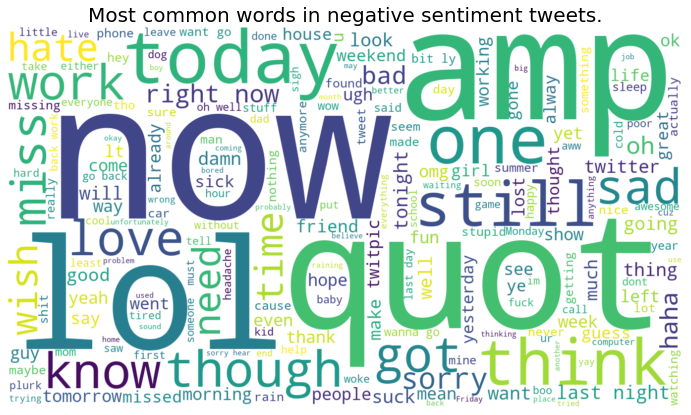

In [ ]:
plt.figure(figsize=(14,7))
word_cloud = WordCloud(stopwords = STOPWORDS, max_words = 200, width=1366, height=768, background_color="white").generate(" ".join(data[data.target=='negative'].text))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in negative sentiment tweets.',fontsize=20)
plt.show()

In [ ]:
# DataFrame new modellllllllllllllllllllllllllllllllllllllllll
import pandas as pd 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB


#tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Utility
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle

In [ ]:
data = data.sample(frac=1)
data = data[:200000]

In [ ]:
print("Dataset shape:", data.shape)

Dataset shape: (200000, 7)


In [ ]:
data['target'].unique()

array(['positive', 'negative'], dtype=object)

In [ ]:
data.describe()

,ids,length
count,2.000000e+05,200000.000000
mean,1.998380e+09,13.178590
std,1.938260e+08,6.971549
min,1.467810e+09,1.000000
25%,1.956842e+09,7.000000
50%,2.002103e+09,12.000000
75%,2.176840e+09,19.000000
max,2.329205e+09,44.000000


In [ ]:
data.drop(['date','flag','user'], axis=1, inplace=True)

In [ ]:
data.drop('ids', axis=1, inplace=True)

In [ ]:
data.head(10)

,target,text,length
1049125,positive,@Treagus well hopefully the film is still in and you can get to see it,15
859203,positive,"@gugod I'm not sure why I'm bothering, anyway -- I don't read any chinese",14
858042,positive,downloading movies,2
690248,negative,ooh &amp; i gots a sore scratch on my arm yesterday so i put a mr bump plaster on it today only cos it didnt go with my dress last night..,31
282429,negative,@RAYning Oh I miss you right now I have my audition but all I'd rather be doing is wrestling with you in bed..lol,23
322356,negative,no one is holding my cold hands and make it warm. that's why i need you here,17
1039344,positive,"listening to Beethoven relaxing, why do i love classical music soo much",12
252635,negative,Grabbing a bite @ Heartland Brewery on Union Square. My time in NYC is quickly drawing to a close.,19
1385644,positive,About to go plymouth shopping with James,7
1586317,positive,"the same here, so excited to go to gocek we will have an amazing holiday but just a bit drinking @petitebeurre",21


In [ ]:
#Checking if any null values present
(data.isnull().sum() / len(data))*100

target    0.0
text      0.0
length    0.0
dtype: float64

In [ ]:
#convrting pandas object to a string type
data['text'] = data['text'].astype('str')

In [ ]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'an', 'who', 'will', "mustn't", 'most', 'his', 'himself', 'weren', 'me', 'him', 'are', 'between', 'why', "doesn't", "wouldn't", 'few', 'down', 'other', 'themselves', 'll', 'any', 'into', 'which', 'having', 'there', 'you', 'more', 've', 'been', 'by', 'now', 'did', "shouldn't", 'each', 'while', "didn't", "hasn't", "that'll", 'too', 'such', 'had', 'aren', "it's", 'being', 'm', 'under', 'this', 'than', 're', 'the', 'doesn', 'hadn', 'ma', "shan't", 'from', 'above', 'during', "she's", 'just', 'their', "isn't", 'in', 'own', 'she', 'of', "should've", 'with', 'yourself', 'how', "weren't", 'if', 'we', 'where', 't', 'yourselves', 'once', 'theirs', 'does', 'yours', "haven't", 'shan', 'isn', 'our', 'them', 'didn', 'needn', 's', 'or', 'these', 'was', 'were', 'but', 'i', 'he', 'again', 'myself', 'at', 'what', 'has', 'couldn', 'y', 'whom', 'then', 'o', 'its', 'about', "don't", 'haven

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [ ]:
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [ ]:
data.head(10)

,target,text,length,processed_tweets
1049125,positive,@Treagus well hopefully the film is still in and you can get to see it,15,treagus well hopefully film still get see
859203,positive,"@gugod I'm not sure why I'm bothering, anyway -- I don't read any chinese",14,gugod im sure im bothering anyway dont read chinese
858042,positive,downloading movies,2,ownloading movie
690248,negative,ooh &amp; i gots a sore scratch on my arm yesterday so i put a mr bump plaster on it today only cos it didnt go with my dress last night..,31,oh amp gots sore scratch arm yesterday put mr bump plaster today co didnt go dress last night
282429,negative,@RAYning Oh I miss you right now I have my audition but all I'd rather be doing is wrestling with you in bed..lol,23,rayning oh miss right audition id rather wrestling bedlol
322356,negative,no one is holding my cold hands and make it warm. that's why i need you here,17,one holding cold hand make warm thats need
1039344,positive,"listening to Beethoven relaxing, why do i love classical music soo much",12,istening beethoven relaxing love classical music soo much
252635,negative,Grabbing a bite @ Heartland Brewery on Union Square. My time in NYC is quickly drawing to a close.,19,rabbing bite heartland brewery union square time nyc quickly drawing close
1385644,positive,About to go plymouth shopping with James,7,bout go plymouth shopping james
1586317,positive,"the same here, so excited to go to gocek we will have an amazing holiday but just a bit drinking @petitebeurre",21,excited go gocek amazing holiday bit drinking


In [ ]:
X = data['processed_tweets'].values
y = data['target'].values

In [ ]:
print(X.shape)
print(y.shape)

(200000,)
(200000,)


In [ ]:
#Convert a collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print(f'Vector fitted.')
print('No. of feature_words: ', len(vector.get_feature_names()))

Vector fitted.
No. of feature_words:  170788


In [ ]:
print(X.shape)
print(y.shape)

(200000, 170788)
(200000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=101)

In [ ]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print()
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (160000, 170788)
y_train (160000,)

X_test (40000, 170788)
y_test (40000,)


In [ ]:
def model_Evaluate(model):
    #accuracy of model on training data
    acc_train=model.score(X_train, y_train)
    #accuracy of model on test data
    acc_test=model.score(X_test, y_test)
    
    print('Accuracy of model on training data : {}'.format(acc_train*100))
    print('Accuracy of model on testing data : {} \n'.format(acc_test*100))

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Accuracy of model on training data : 83.60562499999999
Accuracy of model on testing data : 76.8875 

              precision    recall  f1-score   support

    negative       0.79      0.74      0.76     20048
    positive       0.75      0.80      0.77     19952

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



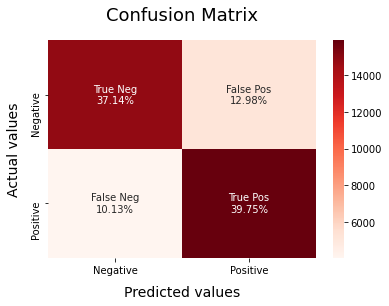

In [ ]:
lg = LogisticRegression()
history=lg.fit(X_train, y_train)
model_Evaluate(lg)

Accuracy of model on training data : 93.19
Accuracy of model on testing data : 75.60249999999999 

              precision    recall  f1-score   support

    negative       0.77      0.74      0.75     20048
    positive       0.75      0.77      0.76     19952

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



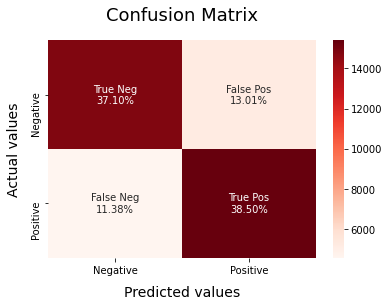

In [ ]:
svm = LinearSVC()
svm.fit(X_train, y_train)
model_Evaluate(svm)

Accuracy of model on training data : 75.655
Accuracy of model on testing data : 70.5725 

              precision    recall  f1-score   support

    negative       0.73      0.65      0.69     20048
    positive       0.68      0.76      0.72     19952

    accuracy                           0.71     40000
   macro avg       0.71      0.71      0.70     40000
weighted avg       0.71      0.71      0.70     40000



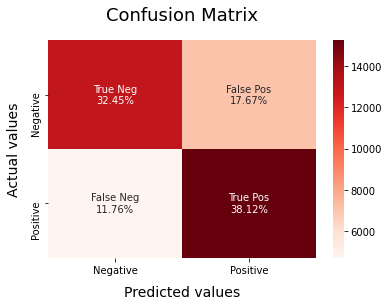

In [ ]:
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)

Accuracy of model on training data : 86.88
Accuracy of model on testing data : 75.69500000000001 

              precision    recall  f1-score   support

    negative       0.75      0.78      0.76     20048
    positive       0.77      0.74      0.75     19952

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



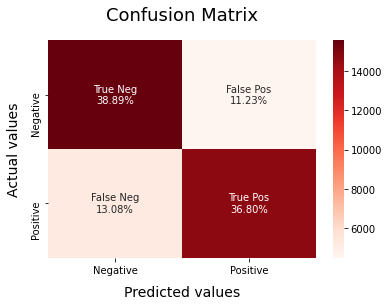

In [ ]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
model_Evaluate(nb)